In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
!python -m pip install --upgrade pip
!python -m pip install keras-tuner

     |████████████████████████████████| 1.5 MB 2.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1
     |████████████████████████████████| 54 kB 1.1 MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73198 sha256=16b67ffd04931bf35d3d2d63de068e31e6f09d73a6227b41f86102f40c145377
  Stored in directory: /root/.cache/pip/wheels/0b/cf/2f/1a1749d3a3650fac3305a8d7f9237b6de7c41068e2f8520ca2
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=b922eb78372a3e98fc51430c0f1dfd72af33b500eb9b54ea41243d56845d7545
  Stored in directory: /root/.cache/pip/wheels/ba/ad/c8/2d98360791161cd3db6daf6b5e730f34021fc9367d5879f497
Successfully built keras-tuner terminaltables


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
# notebook

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0


In [4]:
# Define seed to reprodicibility of random generation
SEED = 42

DEV_SPLIT=0.2

MODE = "DEV"
# MODE = "EVAL"

In [5]:
import random as python_random

# Make sure Keras produces reproducible results.

np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(physical_devices)
for device in (physical_devices or []):
    tf.config.experimental.set_memory_growth(device, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Read data and extract usable features

In [7]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [8]:
features = "Pclass Sex SibSp Parch Fare Embarked Name Cabin Age".split()

X_train_init = train_data[features]
Y_train_init = train_data.Survived

print(X_train_init.shape)
print(Y_train_init.shape)

X_test_init = test_data[features]

print(X_test_init.shape)

(891, 9)
(891,)
(418, 9)


# Split into train/dev sets
## Needs to be done before pre-processing to avoid test-train contamination

In [9]:
from sklearn.model_selection import train_test_split

# if MODE == "DEV":
X_train_unproc, X_dev_unproc, Y_train_unproc, Y_dev_unproc = train_test_split(X_train_init, Y_train_init, test_size=DEV_SPLIT, random_state=SEED)

print(X_train_unproc.shape, Y_train_unproc.shape)
print(X_dev_unproc.shape, Y_dev_unproc.shape)

(712, 9) (712,)
(179, 9) (179,)


## Data observations
*Have NaNs:* Age, Fare (some zeros, nans too), Cabin, Embarked
*NOTE:* maybe need to approximate missing values using some other technique, like an additional model?

* (+) Pclass:
  * 1 - 3 number, 1 being the highest
  * Range: 1-3
  * Current approach: convert to one-hot.
  * Previous approaches:
      * normalize by 3.
* (+) Name:
  * has person's title, which could be used (Mr, Ms, Mrs, etc.)
  * From title, can infer marital status?
  * Current approach: extract titles, replace infrequent ones with "Others", convert them to one-hot, and calculate 'Married' based on title (1 - married (Mr, Mrs), -1 - unmarried (Miss, Master), 0 - unknown (other titles))
  * Potential improvements: use more titles for getting 'married'; use 'maiden name' in calculation of 'married'; use 'nickname' somehow?
* (+) Sex:
  * Either male or female
  * male: 65%, female: 35%
  * Current approach: convert to one-hot.
  * Potential improvements: use 1 and -1 for sexes?
* (+) Age:
  * has fractions if approximated. Has missing values.
  * Range: 0.42-80
  * Current approach: fill NaN with average in group-by Pclass-Sex, but create a column that identifies missing values. Also, normalize by 80.
  * Potential improvements: have a better approximation of age. Convert to age categories?
* (+) SibSp:
  * how many siblings or spouses on board.
  * Range: 0-8
  * Current approach: Add to 'Family'.
  * Previous approaches:
    * normalize by 8.
* (+) Parch:
  * How many parents/children. (can be 0 for babies, if with nannies)
  * Range: 0-6
  * Current approach: Add to 'Family'
  * Previous approachesL
    * normalize by 6.
* Ticket:
  * A number with some optional letters (which can have some meaning?).
  * Has repetitions (maybe for people travelling together).
* (+) Fare:
  * can have zeros (what do they mean?). Can have omitted (just one in test).
  * Range: 0-512.3292
  * Current approach: fill nan with mean, normalize by 512.
  * Potential improvements: most fare is <= 30 USD, so maybe use fare categories.
* (+) Cabin:
  * has a lot of omitted values (78%). Can have multiple values (probably for families?).
  * One value is a letter with a number. (both probably have meaning and impact?)
  * Current approach: convert to one-hot (based on letter), include a 'nan' column for those that are missing values. Create a column for cabin number, and a column to identify missing numbers.
  * Potential improvements: maybe cabin number itself doesn't mean much? Also, maybe need to deal with missing values in a different way? Also, maybe deal with multiple values better?
* (+) Embarked:
  * Either of 3 letters (with different frequency). Has just a few omitted.
  * S - 72/65%, C - 19/24%, Q - 9/11%
  * Current approach: convert to one-hot matrix (fill 2 missing with mode)
  * Potential improvements: somehow take into the account different distribution of embarkation city?

In [10]:
def prepare_data(X):
    # To display all the columns from left to right without breaking into next line.
    pd.set_option('display.width', 1500)

    import re
    
    titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Don', 'Rev', 'Dr', 'Mme', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona']
    
    X = X.copy()
    
    # === Get X - the features. ===

    # == Post-process data ==

#     if "SibSp" in X:
#         X.SibSp = X.SibSp.divide(8)

#     if "Parch" in X:
#         X.Parch = X.Parch.divide(6)
        
    if "Parch" in X and "SibSp" in X:
        X["Family"] = X.Parch + X.SibSp
#         X.Family = X.Family.divide(14)
        X = X.drop(columns="Parch SibSp".split())

    if "Fare" in X:
        # Since only a few would miss 'fare' value, it's okay to fill with average.
        X.Fare = X.Fare.fillna(X.Fare.mean())
        
        X.Fare = np.where(X.Fare < 50, 1, 2)
        
#         X.Fare = X.Fare.divide(512)

    if "Embarked" in X:
        X.Embarked = X.Embarked.fillna(X.Embarked.mode()[0])
        X.Embarked = X.Embarked.astype(pd.api.types.CategoricalDtype(categories="C Q S".split()))
        X = pd.get_dummies(X, columns=["Embarked"])

    if "Name" in X:
        X["Title"] = X.Name.apply(lambda name: re.search(", ([\w ]+).", name).group(1))

        # Try to see if the person is married (1), or not (-1), or unknown (0).
        X["Married"] = X.Title.apply(lambda title: 1 if title in "Mrs Mr".split() else -1 if title in "Miss Master".split() else 0)

        # Get dummies for title
        
        # Include all possible values, even those not present in current dataset.
#         X.Title = X.Title.astype(pd.api.types.CategoricalDtype(categories=titles))
        
        # Titles that are rare are converted to 'Others'
        important_titles = ['Mr', 'Mrs', 'Miss', 'Master']
        X.Title = X.Title.apply(lambda title: title if title in important_titles else "Others")
        
        X = pd.get_dummies(X, columns=["Title"])
        
        # We don't need the name itself.
        X = X.drop(columns=["Name"])
        
    if "Cabin" in X:
        X["Cabin_Missing"] = np.where(X.Cabin.isnull(), 1, 0)
        X.Cabin = X.Cabin.fillna("-")
        
#         X["Cabin_Number"] = X.Cabin.apply(lambda cabin: int(re.search("\w(\d+)", cabin).group(1)) if len(cabin) > 1 else 0)
#         # Do some sort of normalization.
#         X.Cabin_Number = X.Cabin_Number.divide(200)
#         X["Cabin_Number_Missing"] = np.where(X.Cabin_Number == 0, 1, 0)
        
        X.Cabin = X.Cabin.apply(lambda cabin: cabin[:1])
        
        # Convert to one-hot
#         X.Cabin = X.Cabin.astype(pd.api.types.CategoricalDtype(categories=list("ABCDEFGT")))
#         X = pd.get_dummies(X, columns=["Cabin"], dummy_na=True)

        # Convert to numbers with T beeing the lowest deck and S - the highest (sun deck).
        X["Deck_Level"] = X.Cabin.apply(lambda cabin: "SABCDEFGT".find(cabin[0]))
        X = X.drop(columns=["Cabin"])

    if "Age" in X:
        X["Age_Missing"] = np.where(X.Age.isnull(), 1, 0)

        # No need to skip 'nan' for Age when calculating mean, as Pandas does that automatically.
        # 'transform' will go through each group, and fill its nan values with its mean value.
        # Then, all that will be aggregated back into the column, thus replacing nan values with group's mean.
        X["Age"] = X.groupby("Pclass Sex".split())["Age"].transform(lambda x: x.fillna(x.mean()))
        
#         X.Age = X.Age.divide(80)

        # Convert age to categories 1 - child, 2 - young, 3 - older, 4 - senile
        X.Age = pd.cut(X.Age, bins=[0, 16, 30, 50, 80], labels=False) + 1
        
    # Needs to be after 'Age', since age is using original Sex column.
    if "Sex" in X:
        X.Sex = X.Sex.astype(pd.api.types.CategoricalDtype(categories="male female".split()))
        X = pd.get_dummies(X, columns=["Sex"])

    if "Pclass" in X:
        X = pd.get_dummies(X, columns=["Pclass"])
        # Do not normalize small numbers
#         X.Pclass = X.Pclass.divide(3)

    return X

In [11]:
print("Train data:")
X_train = prepare_data(X_train_unproc)
Y_train = Y_train_unproc
print(X_train.head())

print("Dev data:")
X_dev = prepare_data(X_dev_unproc)
Y_dev = Y_dev_unproc
print(X_dev.head())

print("Test data:")
X_test = prepare_data(X_test_init)
print(X_test.head())

Train data:
     Fare  Age  Family  Embarked_C  Embarked_Q  Embarked_S  Married  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Others  Cabin_Missing  Deck_Level  Age_Missing  Sex_male  Sex_female  Pclass_1  Pclass_2  Pclass_3
331     1    3       0           0           0           1        1             0           0         1          0             0              0           3            0         1           0         1         0         0
733     1    2       0           0           0           1        1             0           0         1          0             0              1          -1            0         1           0         0         1         0
382     1    3       0           0           0           1        1             0           0         1          0             0              1          -1            0         1           0         0         0         1
704     1    2       1           0           0           1        1             0           0         1 

# DL model using Keras

In [12]:
def get_model(input_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Dense(128, input_shape=(input_size,), activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(20, activation="relu", kernel_regularizer=l2(0.01)),
        Dropout(0.25),
        Dense(6, activation="tanh", kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3), metrics=["accuracy"], loss="binary_crossentropy")
    
    return model

In [13]:
model = get_model(X_train.shape[1])

In [14]:
history = model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_data=(X_dev, Y_dev))

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 2s 3ms/sample - loss: 1.7489 - accuracy: 0.6053 - val_loss: 1.5734 - val_accuracy: 0.7039
Epoch 2/500
712/712 [==============================] - 0s 140us/sample - loss: 1.5003 - accuracy: 0.6784 - val_loss: 1.3451 - val_accuracy: 0.7709
Epoch 3/500
712/712 [==============================] - 0s 143us/sample - loss: 1.2977 - accuracy: 0.7275 - val_loss: 1.1800 - val_accuracy: 0.8101
Epoch 4/500
712/712 [==============================] - 0s 138us/sample - loss: 1.1564 - accuracy: 0.7823 - val_loss: 1.0512 - val_accuracy: 0.8156
Epoch 5/500
712/712 [==============================] - 0s 138us/sample - loss: 1.0548 - accuracy: 0.7809 - val_loss: 0.9620 - val_accuracy: 0.7877
Epoch 6/500
712/712 [==============================] - 0s 130us/sample - loss: 0.9695 - accuracy: 0.8090 - val_loss: 0.8843 - val_accuracy: 0.8045
Epoch 7/500
712/712 [==============================] - 0s 137us/sample - l

# Results of the DL model

In [15]:
def plot_model_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


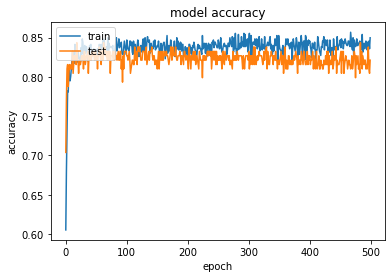

In [16]:
plot_model_history(history)

In [17]:
_, accuracy = model.evaluate(X_train, Y_train, verbose=2)

print('\nTrain accuracy:', accuracy)

712/712 - 0s - loss: 0.4166 - accuracy: 0.8539

Train accuracy: 0.85393256


In [18]:
_, accuracy = model.evaluate(X_dev, Y_dev, verbose=2)

print('\nDev accuracy:', accuracy)

179/179 - 0s - loss: 0.4980 - accuracy: 0.8212

Dev accuracy: 0.82122904


# Tune hyperparameters for the DL model

In [19]:
from kerastuner import HyperModel

# https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner
# https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/

class TitanicHyperModel(HyperModel):
    def __init__(self, input_size):
        self.input_shape = (input_size, )

    def build(self, hp):
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout
#         from tensorflow.keras.regularizers import L1L2

        model = Sequential()
        
        for layer_n in range(hp.Int("num_layers", min_value=1, max_value=6, step=1, default=6) + 1):
            units = hp.Int(
                f"dense_units_{layer_n}",
                min_value=8,
                max_value=64,
                step=8,
                default=64
            )
            activation = hp.Choice(
                f"dense_activation_{layer_n}",
                values=['relu', 'tanh', 'sigmoid'],
                default='relu'
            )
#             regularizer_l1 = hp.Float(
#                 f'l1_{layer_n}',
#                 min_value=1e-5,
#                 max_value=0.1,
#                 sampling='LOG',
#                 default=0
#             )
#             regularizer_l2 = hp.Float(
#                 f'l2_{layer_n}',
#                 min_value=1e-5,
#                 max_value=0.1,
#                 sampling='LOG',
#                 default=0.01
#             )
            
            input_shape_params = {"input_shape": self.input_shape} if layer_n == 0 else {}
            model.add(Dense(units=units, **input_shape_params, activation=activation)) #, kernel_regularizer=L1L2(l1=regularizer_l1, l2=regularizer_l2)))
            
            droupout_rate = hp.Float(
                f'dropout_{layer_n}',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )
            
            model.add(Dropout(rate=droupout_rate))
        
        model.add(Dense(1, activation="sigmoid"))
        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            metrics=["accuracy"],
            loss="binary_crossentropy",
        )

        return model

hypermodel = TitanicHyperModel(input_size=X_train.shape[1])

In [20]:
# Dev mode

if MODE == "DEV":
    MAX_TRIALS = 20
    EXECUTION_PER_TRIAL = 2
    N_EPOCH_SEARCH = 20
else:
    MAX_TRIALS = 200
    EXECUTION_PER_TRIAL = 3
    N_EPOCH_SEARCH = 400

In [21]:
from kerastuner.tuners import RandomSearch

try:
    ATTEMPT = ATTEMPT + 1
except NameError:
    ATTEMPT = 0

tuner = RandomSearch(
    hypermodel,
    objective="val_accuracy",
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory=f'random_search_{ATTEMPT}',
    project_name='titanic'
)

tuner.search_space_summary()

In [22]:
tuner.search(X_train, Y_train, epochs=N_EPOCH_SEARCH, validation_data=(X_dev, Y_dev))

tuner.results_summary()

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.7150 - accuracy: 0.4803 - val_loss: 0.6761 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 142us/sample - loss: 0.6592 - accuracy: 0.6194 - val_loss: 0.6830 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 145us/sample - loss: 0.6665 - accuracy: 0.6236 - val_loss: 0.6748 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 138us/sample - loss: 0.6634 - accuracy: 0.6194 - val_loss: 0.6626 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 140us/sample - loss: 0.6447 - accuracy: 0.6278 - val_loss: 0.6456 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 148us/sample - loss: 0.6394 - accuracy: 0.6503 - val_loss: 0.6115 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 176us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.7926 - accuracy: 0.4775 - val_loss: 0.7345 - val_accuracy: 0.3855
Epoch 2/20
712/712 [==============================] - 0s 195us/sample - loss: 0.7591 - accuracy: 0.5140 - val_loss: 0.6981 - val_accuracy: 0.4413
Epoch 3/20
712/712 [==============================] - 0s 163us/sample - loss: 0.7054 - accuracy: 0.5744 - val_loss: 0.6807 - val_accuracy: 0.5922
Epoch 4/20
712/712 [==============================] - 0s 135us/sample - loss: 0.7017 - accuracy: 0.5913 - val_loss: 0.6735 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 156us/sample - loss: 0.7000 - accuracy: 0.5801 - val_loss: 0.6685 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 140us/sample - loss: 0.6803 - accuracy: 0.6152 - val_loss: 0.6615 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 140us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.5853 - accuracy: 0.6840 - val_loss: 0.5151 - val_accuracy: 0.7765
Epoch 2/20
712/712 [==============================] - 0s 172us/sample - loss: 0.4796 - accuracy: 0.7837 - val_loss: 0.4618 - val_accuracy: 0.7877
Epoch 3/20
712/712 [==============================] - 0s 160us/sample - loss: 0.4381 - accuracy: 0.8062 - val_loss: 0.4567 - val_accuracy: 0.8045
Epoch 4/20
712/712 [==============================] - 0s 172us/sample - loss: 0.4655 - accuracy: 0.8006 - val_loss: 0.4468 - val_accuracy: 0.8324
Epoch 5/20
712/712 [==============================] - 0s 146us/sample - loss: 0.4146 - accuracy: 0.8357 - val_loss: 0.4511 - val_accuracy: 0.7821
Epoch 6/20
712/712 [==============================] - 0s 143us/sample - loss: 0.4325 - accuracy: 0.8132 - val_loss: 0.4538 - val_accuracy: 0.8268
Epoch 7/20
712/712 [==============================] - 0s 143us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6726 - accuracy: 0.6067 - val_loss: 0.6751 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 144us/sample - loss: 0.6640 - accuracy: 0.6194 - val_loss: 0.6677 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 145us/sample - loss: 0.6560 - accuracy: 0.6250 - val_loss: 0.6516 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 154us/sample - loss: 0.6391 - accuracy: 0.6236 - val_loss: 0.6114 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 149us/sample - loss: 0.6033 - accuracy: 0.6222 - val_loss: 0.5639 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 161us/sample - loss: 0.5771 - accuracy: 0.6236 - val_loss: 0.5305 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 218us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.7163 - accuracy: 0.5660 - val_loss: 0.6887 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 139us/sample - loss: 0.6958 - accuracy: 0.5969 - val_loss: 0.6842 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 136us/sample - loss: 0.6952 - accuracy: 0.5941 - val_loss: 0.6802 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 133us/sample - loss: 0.6833 - accuracy: 0.5815 - val_loss: 0.6779 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 141us/sample - loss: 0.6712 - accuracy: 0.6110 - val_loss: 0.6643 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 146us/sample - loss: 0.6669 - accuracy: 0.6053 - val_loss: 0.6577 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 146us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6949 - accuracy: 0.5913 - val_loss: 0.5663 - val_accuracy: 0.7989
Epoch 2/20
712/712 [==============================] - 0s 140us/sample - loss: 0.5417 - accuracy: 0.7584 - val_loss: 0.4765 - val_accuracy: 0.7933
Epoch 3/20
712/712 [==============================] - 0s 163us/sample - loss: 0.4710 - accuracy: 0.8216 - val_loss: 0.4530 - val_accuracy: 0.8156
Epoch 4/20
712/712 [==============================] - 0s 172us/sample - loss: 0.4774 - accuracy: 0.8230 - val_loss: 0.4533 - val_accuracy: 0.8212
Epoch 5/20
712/712 [==============================] - 0s 165us/sample - loss: 0.4420 - accuracy: 0.8357 - val_loss: 0.4424 - val_accuracy: 0.8268
Epoch 6/20
712/712 [==============================] - 0s 157us/sample - loss: 0.4302 - accuracy: 0.8258 - val_loss: 0.4436 - val_accuracy: 0.8268
Epoch 7/20
712/712 [==============================] - 0s 139us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 955us/sample - loss: 0.6611 - accuracy: 0.6053 - val_loss: 0.5433 - val_accuracy: 0.7207
Epoch 2/20
712/712 [==============================] - 0s 177us/sample - loss: 0.5381 - accuracy: 0.7444 - val_loss: 0.4358 - val_accuracy: 0.8045
Epoch 3/20
712/712 [==============================] - 0s 166us/sample - loss: 0.4788 - accuracy: 0.7949 - val_loss: 0.4362 - val_accuracy: 0.8101
Epoch 4/20
712/712 [==============================] - 0s 163us/sample - loss: 0.4536 - accuracy: 0.8006 - val_loss: 0.4351 - val_accuracy: 0.8156
Epoch 5/20
712/712 [==============================] - 0s 142us/sample - loss: 0.4314 - accuracy: 0.8258 - val_loss: 0.4341 - val_accuracy: 0.8156
Epoch 6/20
712/712 [==============================] - 0s 168us/sample - loss: 0.4228 - accuracy: 0.8244 - val_loss: 0.4345 - val_accuracy: 0.8212
Epoch 7/20
712/712 [==============================] - 0s 159us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 849us/sample - loss: 0.6064 - accuracy: 0.6601 - val_loss: 0.4496 - val_accuracy: 0.8045
Epoch 2/20
712/712 [==============================] - 0s 177us/sample - loss: 0.4751 - accuracy: 0.7823 - val_loss: 0.4226 - val_accuracy: 0.8101
Epoch 3/20
712/712 [==============================] - 0s 220us/sample - loss: 0.4561 - accuracy: 0.8034 - val_loss: 0.4302 - val_accuracy: 0.8045
Epoch 4/20
712/712 [==============================] - 0s 152us/sample - loss: 0.4295 - accuracy: 0.8244 - val_loss: 0.4249 - val_accuracy: 0.8156
Epoch 5/20
712/712 [==============================] - 0s 130us/sample - loss: 0.4275 - accuracy: 0.8287 - val_loss: 0.4324 - val_accuracy: 0.8045
Epoch 6/20
712/712 [==============================] - 0s 142us/sample - loss: 0.4187 - accuracy: 0.8385 - val_loss: 0.4295 - val_accuracy: 0.8101
Epoch 7/20
712/712 [==============================] - 0s 158us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6850 - accuracy: 0.5955 - val_loss: 0.6085 - val_accuracy: 0.6704
Epoch 2/20
712/712 [==============================] - 0s 160us/sample - loss: 0.5897 - accuracy: 0.7079 - val_loss: 0.4555 - val_accuracy: 0.7989
Epoch 3/20
712/712 [==============================] - 0s 143us/sample - loss: 0.5479 - accuracy: 0.7486 - val_loss: 0.4801 - val_accuracy: 0.7486
Epoch 4/20
712/712 [==============================] - 0s 138us/sample - loss: 0.5435 - accuracy: 0.7388 - val_loss: 0.4487 - val_accuracy: 0.7877
Epoch 5/20
712/712 [==============================] - 0s 162us/sample - loss: 0.4900 - accuracy: 0.7823 - val_loss: 0.4437 - val_accuracy: 0.8045
Epoch 6/20
712/712 [==============================] - 0s 135us/sample - loss: 0.4584 - accuracy: 0.8062 - val_loss: 0.4621 - val_accuracy: 0.7765
Epoch 7/20
712/712 [==============================] - 0s 133us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 931us/sample - loss: 0.6992 - accuracy: 0.5674 - val_loss: 0.5784 - val_accuracy: 0.6927
Epoch 2/20
712/712 [==============================] - 0s 198us/sample - loss: 0.6013 - accuracy: 0.6840 - val_loss: 0.5015 - val_accuracy: 0.7430
Epoch 3/20
712/712 [==============================] - 0s 154us/sample - loss: 0.5656 - accuracy: 0.7275 - val_loss: 0.4622 - val_accuracy: 0.7877
Epoch 4/20
712/712 [==============================] - 0s 182us/sample - loss: 0.5479 - accuracy: 0.7261 - val_loss: 0.4382 - val_accuracy: 0.8212
Epoch 5/20
712/712 [==============================] - 0s 283us/sample - loss: 0.5429 - accuracy: 0.7289 - val_loss: 0.4255 - val_accuracy: 0.8268
Epoch 6/20
712/712 [==============================] - 0s 246us/sample - loss: 0.5325 - accuracy: 0.7514 - val_loss: 0.4193 - val_accuracy: 0.8324
Epoch 7/20
712/712 [==============================] - 0s 219us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6808 - accuracy: 0.5562 - val_loss: 0.6754 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 159us/sample - loss: 0.6724 - accuracy: 0.6025 - val_loss: 0.6738 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 151us/sample - loss: 0.6802 - accuracy: 0.6124 - val_loss: 0.6697 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 161us/sample - loss: 0.6698 - accuracy: 0.6180 - val_loss: 0.6667 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 153us/sample - loss: 0.6650 - accuracy: 0.6180 - val_loss: 0.6637 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 153us/sample - loss: 0.6678 - accuracy: 0.6264 - val_loss: 0.6597 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 147us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.8046 - accuracy: 0.4073 - val_loss: 0.6912 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 152us/sample - loss: 0.6883 - accuracy: 0.5801 - val_loss: 0.6831 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 153us/sample - loss: 0.6934 - accuracy: 0.5913 - val_loss: 0.6814 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 153us/sample - loss: 0.6940 - accuracy: 0.5801 - val_loss: 0.6763 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 150us/sample - loss: 0.6812 - accuracy: 0.5730 - val_loss: 0.6784 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 140us/sample - loss: 0.6928 - accuracy: 0.5843 - val_loss: 0.6746 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 145us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.7319 - accuracy: 0.5253 - val_loss: 0.6726 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 143us/sample - loss: 0.6902 - accuracy: 0.5829 - val_loss: 0.6655 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 136us/sample - loss: 0.6808 - accuracy: 0.6096 - val_loss: 0.6513 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 139us/sample - loss: 0.6758 - accuracy: 0.5983 - val_loss: 0.6426 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 145us/sample - loss: 0.6526 - accuracy: 0.6222 - val_loss: 0.6272 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 148us/sample - loss: 0.6512 - accuracy: 0.6208 - val_loss: 0.6158 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 185us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.7024 - accuracy: 0.5548 - val_loss: 0.6930 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 137us/sample - loss: 0.6898 - accuracy: 0.5941 - val_loss: 0.6499 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 138us/sample - loss: 0.6473 - accuracy: 0.6236 - val_loss: 0.6314 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 209us/sample - loss: 0.6168 - accuracy: 0.6419 - val_loss: 0.5189 - val_accuracy: 0.7598
Epoch 5/20
712/712 [==============================] - 0s 251us/sample - loss: 0.5358 - accuracy: 0.7570 - val_loss: 0.4542 - val_accuracy: 0.7709
Epoch 6/20
712/712 [==============================] - 0s 247us/sample - loss: 0.5448 - accuracy: 0.7556 - val_loss: 0.4651 - val_accuracy: 0.8324
Epoch 7/20
712/712 [==============================] - 0s 201us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6282 - accuracy: 0.6081 - val_loss: 0.5498 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 169us/sample - loss: 0.5256 - accuracy: 0.7402 - val_loss: 0.4865 - val_accuracy: 0.7989
Epoch 3/20
712/712 [==============================] - 0s 170us/sample - loss: 0.4747 - accuracy: 0.8202 - val_loss: 0.4497 - val_accuracy: 0.8045
Epoch 4/20
712/712 [==============================] - 0s 144us/sample - loss: 0.4714 - accuracy: 0.8104 - val_loss: 0.4292 - val_accuracy: 0.8045
Epoch 5/20
712/712 [==============================] - 0s 174us/sample - loss: 0.4265 - accuracy: 0.8202 - val_loss: 0.4390 - val_accuracy: 0.8156
Epoch 6/20
712/712 [==============================] - 0s 140us/sample - loss: 0.4239 - accuracy: 0.8216 - val_loss: 0.4357 - val_accuracy: 0.8101
Epoch 7/20
712/712 [==============================] - 0s 143us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 978us/sample - loss: 0.7098 - accuracy: 0.5913 - val_loss: 0.6806 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 167us/sample - loss: 0.6239 - accuracy: 0.6615 - val_loss: 0.5315 - val_accuracy: 0.7207
Epoch 3/20
712/712 [==============================] - 0s 167us/sample - loss: 0.5421 - accuracy: 0.7303 - val_loss: 0.4617 - val_accuracy: 0.7765
Epoch 4/20
712/712 [==============================] - 0s 139us/sample - loss: 0.4910 - accuracy: 0.7711 - val_loss: 0.4541 - val_accuracy: 0.7765
Epoch 5/20
712/712 [==============================] - 0s 168us/sample - loss: 0.4625 - accuracy: 0.7992 - val_loss: 0.4437 - val_accuracy: 0.7877
Epoch 6/20
712/712 [==============================] - 0s 174us/sample - loss: 0.4436 - accuracy: 0.7992 - val_loss: 0.4363 - val_accuracy: 0.8101
Epoch 7/20
712/712 [==============================] - 0s 149us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 914us/sample - loss: 0.6753 - accuracy: 0.5829 - val_loss: 0.5435 - val_accuracy: 0.7095
Epoch 2/20
712/712 [==============================] - 0s 152us/sample - loss: 0.5578 - accuracy: 0.7247 - val_loss: 0.4769 - val_accuracy: 0.8101
Epoch 3/20
712/712 [==============================] - 0s 130us/sample - loss: 0.5394 - accuracy: 0.7416 - val_loss: 0.4641 - val_accuracy: 0.8045
Epoch 4/20
712/712 [==============================] - 0s 137us/sample - loss: 0.5254 - accuracy: 0.7514 - val_loss: 0.4502 - val_accuracy: 0.7989
Epoch 5/20
712/712 [==============================] - 0s 134us/sample - loss: 0.5069 - accuracy: 0.7781 - val_loss: 0.4443 - val_accuracy: 0.8101
Epoch 6/20
712/712 [==============================] - 0s 164us/sample - loss: 0.4836 - accuracy: 0.7921 - val_loss: 0.4407 - val_accuracy: 0.8212
Epoch 7/20
712/712 [==============================] - 0s 131us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 936us/sample - loss: 0.6281 - accuracy: 0.6489 - val_loss: 0.4601 - val_accuracy: 0.8156
Epoch 2/20
712/712 [==============================] - 0s 133us/sample - loss: 0.5030 - accuracy: 0.7795 - val_loss: 0.4279 - val_accuracy: 0.8101
Epoch 3/20
712/712 [==============================] - 0s 135us/sample - loss: 0.4626 - accuracy: 0.8118 - val_loss: 0.4342 - val_accuracy: 0.8045
Epoch 4/20
712/712 [==============================] - 0s 141us/sample - loss: 0.4392 - accuracy: 0.8244 - val_loss: 0.4370 - val_accuracy: 0.8156
Epoch 5/20
712/712 [==============================] - 0s 130us/sample - loss: 0.4419 - accuracy: 0.8272 - val_loss: 0.4508 - val_accuracy: 0.8045
Epoch 6/20
712/712 [==============================] - 0s 158us/sample - loss: 0.4126 - accuracy: 0.8287 - val_loss: 0.4189 - val_accuracy: 0.8268
Epoch 7/20
712/712 [==============================] - 0s 162us/sample - loss: 

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 2ms/sample - loss: 0.6854 - accuracy: 0.5899 - val_loss: 0.6603 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 183us/sample - loss: 0.6457 - accuracy: 0.6320 - val_loss: 0.4967 - val_accuracy: 0.7933
Epoch 3/20
712/712 [==============================] - 0s 180us/sample - loss: 0.5873 - accuracy: 0.6868 - val_loss: 0.4754 - val_accuracy: 0.7877
Epoch 4/20
712/712 [==============================] - 0s 249us/sample - loss: 0.5476 - accuracy: 0.7725 - val_loss: 0.4876 - val_accuracy: 0.8101
Epoch 5/20
712/712 [==============================] - 0s 253us/sample - loss: 0.4994 - accuracy: 0.7963 - val_loss: 0.4678 - val_accuracy: 0.7989
Epoch 6/20
712/712 [==============================] - 0s 307us/sample - loss: 0.4878 - accuracy: 0.8006 - val_loss: 0.4710 - val_accuracy: 0.8045
Epoch 7/20
712/712 [==============================] - 0s 295us/sample - loss: 0.

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 1s 1ms/sample - loss: 0.6995 - accuracy: 0.5843 - val_loss: 0.6811 - val_accuracy: 0.5866
Epoch 2/20
712/712 [==============================] - 0s 155us/sample - loss: 0.6781 - accuracy: 0.6110 - val_loss: 0.6802 - val_accuracy: 0.5866
Epoch 3/20
712/712 [==============================] - 0s 152us/sample - loss: 0.6788 - accuracy: 0.6081 - val_loss: 0.6798 - val_accuracy: 0.5866
Epoch 4/20
712/712 [==============================] - 0s 170us/sample - loss: 0.6803 - accuracy: 0.6166 - val_loss: 0.6781 - val_accuracy: 0.5866
Epoch 5/20
712/712 [==============================] - 0s 150us/sample - loss: 0.6687 - accuracy: 0.6180 - val_loss: 0.6801 - val_accuracy: 0.5866
Epoch 6/20
712/712 [==============================] - 0s 161us/sample - loss: 0.6671 - accuracy: 0.6194 - val_loss: 0.6799 - val_accuracy: 0.5866
Epoch 7/20
712/712 [==============================] - 0s 158us/sample - loss: 0.

# Results of the tuning

In [23]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'num_layers': 5,
 'dense_units_0': 48,
 'dense_activation_0': 'relu',
 'dropout_0': 0.0,
 'dense_units_1': 56,
 'dense_activation_1': 'tanh',
 'dropout_1': 0.05,
 'dense_units_2': 24,
 'dense_activation_2': 'relu',
 'dropout_2': 0.0,
 'dense_units_3': 24,
 'dense_activation_3': 'relu',
 'dropout_3': 0.35000000000000003,
 'dense_units_4': 24,
 'dense_activation_4': 'relu',
 'dropout_4': 0.0,
 'dense_units_5': 56,
 'dense_activation_5': 'tanh',
 'dropout_5': 0.05,
 'dense_units_6': 40,
 'dense_activation_6': 'sigmoid',
 'dropout_6': 0.45,
 'learning_rate': 0.001753559151044536}

In [24]:
print("Best model")

# Get the best model tuned.
best_model = tuner.get_best_models(num_models=1)[0]

_, accuracy = best_model.evaluate(X_train, Y_train)
print(f"Tuned train accuracy: {accuracy}")

_, accuracy = best_model.evaluate(X_dev, Y_dev)
print(f"Tuned dev accuracy: {accuracy}")

best_model.summary()

Best model
712/712 [==============================] - 0s 224us/sample - loss: 0.3750 - accuracy: 0.8483
Tuned train accuracy: 0.8483145833015442
179/179 [==============================] - 0s 93us/sample - loss: 0.4159 - accuracy: 0.8547
Tuned dev accuracy: 0.8547486066818237
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                1008      
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                2744      
_________________________________________________________________
dropout_1 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)     

# Predict

In [25]:
def store_predictions(model, submission_name):
    predictions = model.predict(X_test)

    predictions = np.round(predictions).astype(np.uint8).reshape((-1))

    print(f"{submission_name}:\n{predictions}")
    
    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
    output.to_csv(f"{submission_name}.csv", index=False)

In [26]:
store_predictions(model, "dl_submission")
store_predictions(best_model, "dl_tuned_submission")

dl_submission:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 0 0 1]
dl_tuned_submission:
[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0